<a href="https://colab.research.google.com/github/pbuslaev/cphmd_ligand_param/blob/main/prep_ligand_for_gmx_cphmd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook has to be run on Google colab

<a target="_blank" href="https://colab.research.google.com/github/pbuslaev/test_ipynb/blob/main/test_user_input.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#@title Conda installation
%%capture
!pip install -q condacolab
import condacolab
condacolab.install()

In [2]:
#@title Intall packages
%%capture
!pip install dimorphite_dl --upgrade
!mamba install -c conda-forge rdkit sympy openff-toolkit

In [3]:
#@title Import packages
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
from IPython.display import SVG
from dimorphite_dl import DimorphiteDL

from openff.toolkit import Molecule, Topology, ForceField

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
  get_ipython().events.register('pre_run_cell', set_css)

This is Molecule 0


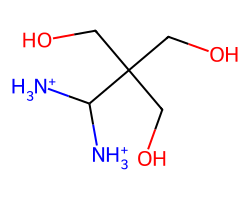

This is Molecule 1


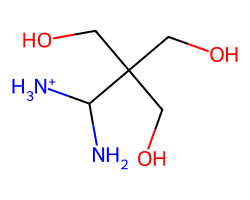

This is Molecule 2


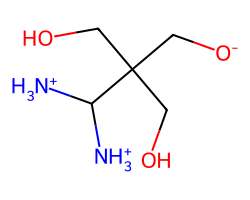

This is Molecule 3


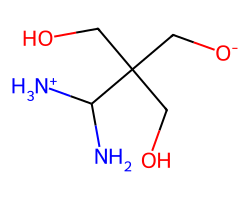

This is Molecule 4


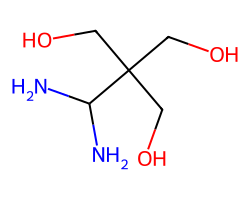

This is Molecule 5


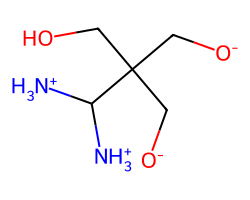

This is Molecule 6


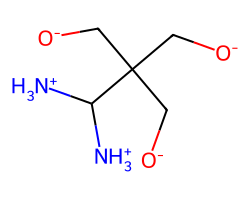

This is Molecule 7


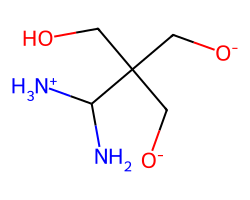

This is Molecule 8


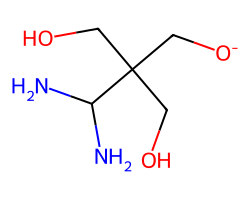

This is Molecule 9


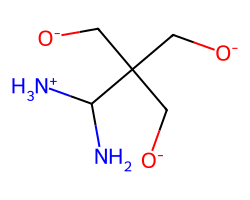

This is Molecule 10


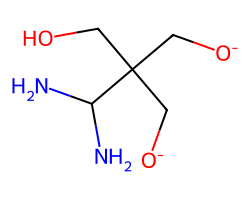

This is Molecule 11


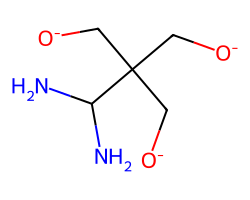

In [176]:
#@title Input molecule
#@markdown Please provide molecule SMILES. We will generate its protonation
#@markdown states. Also, specify pH range for which to create states.
# As a two state example we will use SM-26 from SAMP7 challenge
# (https://github.com/samplchallenges/SAMPL7/tree/master/physical_property)
# SMILES: O=S(CCC1=CC=CC=C1)(NC(C)=O)=O
# test 1: c1cc(N)c(N)cc1
# test 2: c1cc(CO)cc(CO)c1
# pKa = 4.91
# (https://github.com/samplchallenges/SAMPL7/blob/master/physical_property/experimental_data/Experimental_Properties_of_SAMPL7_Compounds.pdf)
smiles = "C(CO)(CO)(CO)[C@H](N)N" #@param {type: "string"}
min_ph = -10 #@param {type: "number"}
max_ph = 24 #@param {type: "number"}
dimorphite_dl = DimorphiteDL(
    min_ph=min_ph,
    max_ph=max_ph,
    max_variants=256,
    label_states=False,
    pka_precision=0.1
)
mols = [Chem.MolFromSmiles(mol) for mol in dimorphite_dl.protonate(smiles)]
mols = sorted(mols, key = lambda x: Chem.GetFormalCharge(x), reverse=True)
# Now mols[0] is the highest protonation state
for i, m in enumerate(mols):
    print(f"This is Molecule {i}")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))

In [177]:
Chem.MolToSmiles(pmol)

'[NH3+]C([NH3+])C(CO)(CO)CO'

In [178]:
#@title Select molecules
#@markdown Which molecule states do you want to use?
#@markdown The molecule ids are shown in the previous cell.
mol1 = True #@param {type:"boolean"}
mol2 = True #@param {type:"boolean"}
mol3 = True #@param {type:"boolean"}
mol4 = True #@param {type:"boolean"}
mol5 = True #@param {type:"boolean"}
mol6 = False #@param {type:"boolean"}
mol7 = False #@param {type:"boolean"}
mol8 = False #@param {type:"boolean"}
mol9 = False #@param {type:"boolean"}
mol10 = False #@param {type:"boolean"}

mols_to_use = [
    mol1, mol2, mol3, mol4, mol5, mol6, mol7, mol8, mol9, mol10, False, False
][:len(mols)]

mols_for_use = [mols[i] for i in range(len(mols)) if mols_to_use[i]]

This is Molecule 0


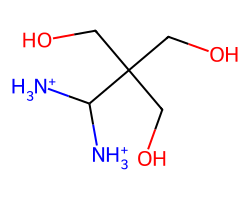

This is Molecule 1


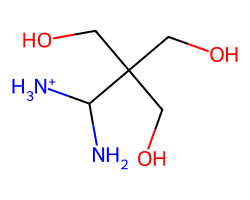

This is Molecule 2


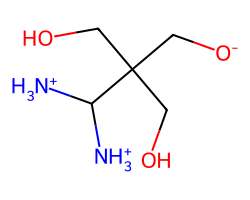

This is Molecule 3


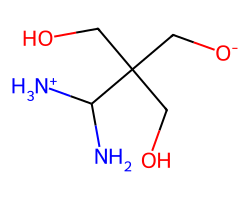

This is Molecule 4


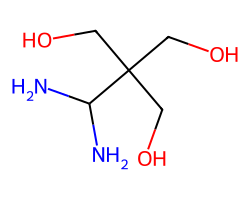

In [179]:
#@title Selected molecules
#@markdown The foloweing molecules will be used in the furhter analysis.
for i, m in enumerate(mols_for_use):
    print(f"This is Molecule {i}")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))

In [180]:
#@title Get titratable site
# Highest protonation state is always in state[0]
from copy import deepcopy

titratable_sites = []
# Dictionary of molecular states
mol_states = {}
# pmol is a protonated molecule - always in the highest available protonation
# state
pmol = mols[0]
from rdkit.Chem import rdFMCS
res = rdFMCS.FindMCS([pmol, pmol])
similar_patt = Chem.MolFromSmarts(res.smartsString)
# This is a constant mol[0] substructure match
subst_matches_pmol = pmol.GetSubstructMatches(similar_patt)[0]
mol_states[0] = [
    {
        "heavy_atom_mapping": {x: x for x in subst_matches_pmol},  # mapping to pmol heavy atoms
        "h_formal_charges": {
            x: [1] * (
                pmol.GetAtomWithIdx(x).GetNumImplicitHs() +
                pmol.GetAtomWithIdx(x).GetNumExplicitHs()
            ) for x in range(pmol.GetNumAtoms())
        },  # mapping to hydrogen formal charges in the pmol indexing
        "use": True,  # Flag for using this state
        "mol": deepcopy(pmol),  # molecule
    }
]
for i, m in enumerate(mols[1:]):
    subst_matches = m.GetSubstructMatches(similar_patt)[0]
    mol_states[i + 1] = [
        {
            "heavy_atom_mapping": {
                a: a0 for a0, a in zip(subst_matches_pmol, subst_matches)
            },  # mapping to pmol heavy atoms
            "h_formal_charges": {
                x: [1] * (
                    pmol.GetAtomWithIdx(x).GetNumImplicitHs() +
                    pmol.GetAtomWithIdx(x).GetNumExplicitHs()
                ) for x in range(pmol.GetNumAtoms())
            },  # mapping to hydrogen formal charges in the pmol indexing
            "use": True,  # Flag for using this state
            "mol": deepcopy(m),  # molecule
        }
    ]
    for a0, a in zip(subst_matches_pmol, subst_matches):
        if (pmol.GetAtomWithIdx(a0).GetFormalCharge() !=
            m.GetAtomWithIdx(a).GetFormalCharge()
        ):
            titratable_sites.append(a0)
        _n_pmol_h = len(mol_states[i + 1][0]["h_formal_charges"][a0])
        if (
            m.GetAtomWithIdx(a).GetNumImplicitHs() +
            m.GetAtomWithIdx(a).GetNumExplicitHs() !=
            _n_pmol_h
        ):
            diff = (
                _n_pmol_h -
                m.GetAtomWithIdx(a).GetNumImplicitHs() -
                m.GetAtomWithIdx(a).GetNumExplicitHs()
            )
            assert diff > 0, "Not possible, since pmol is highest protonation state"
            mol_states[i + 1][0]["h_formal_charges"][a0] = [1] * (
                m.GetAtomWithIdx(a).GetNumImplicitHs() +
                m.GetAtomWithIdx(a).GetNumExplicitHs()
            ) + [0] * diff

for i in mol_states:
    if not mols_to_use[i]:
        mol_states[i][0]["use"] = False

titratable_sites = list(set(titratable_sites))

In [181]:
#@title Generate symmetrical states
from rdkit.Chem import rdFMCS
# We search for symmetrical sites based on the highest protonation states
# NOTE: If the user selects not to include the highest protonation state
# this behaviour can cause problems.
# The indexing of symmetrical sites is for pmol indexing
res = rdFMCS.FindMCS([pmol, pmol])
similar_patt = Chem.MolFromSmarts(res.smartsString)

# We look for all possible substructure matches
sym_subst_matches = pmol.GetSubstructMatches(similar_patt, uniquify=False)
subst_matches = sym_subst_matches
#print(subst_matches)
# We create a dictionary of symmetrical sites and substructure machings
# for each atom
symmetrical_sites = {
    x.GetIdx():[{"idx": x.GetIdx(), "mapping": subst_matches[0]}]
    for x in pmol.GetAtoms()
}
# We save all possible mappings. Then, when generating symmetrical mol_states
# we will only save states, if charges are not present in the charge list
if len(subst_matches) > 1:
    for sm in subst_matches[1:]:
        for ts in titratable_sites:
            symmetrical_sites[ts].append(
                {
                    "idx": sm[subst_matches_pmol.index(ts)],
                    "mapping": sm,
                }
            )

def _get_formal_charges(mol: Chem.rdchem.Mol) -> dict[int, int]:
    """
    Get dictionary of formal charges for a molecule.

    Parameters
    ----------
    mol: rdkit.Chem.rdchem.Mol
        Rdkit Molecule.

    Returns
    -------
    Dictionary with atom index as key, and atom charge as value.
    Indexing in the molecule indexing.
    """
    return {x.GetIdx(): x.GetFormalCharge() for x in mol.GetAtoms()}

def _reshufle_charges_to_pmol_indexing(
    charge_dict: dict[int, int], mapping: dict[int, int]
) -> dict[int, int]:
    """
    Reassignes indices to pmol indexing

    Parameters
    ----------
    charge_dict: dict[int, int]
        Dictionary of charges in arbitrary indexing system.
    mapping: dict[int, int]
        Mapping of indexing to pmole indexing.

    Returns
    -------
    Dictionary with mapped to pmol atom index as key, and atom charge as value.
    """
    return {mapping[x]: charge_dict[x] for x in charge_dict}

for idx, mol in enumerate(mols):
    _tmp = mol_states[idx][0]
    # Generate dictionary of formal charges
    charges = _get_formal_charges(mol)
    # Reorder charges to pmol indexing
    charges = _reshufle_charges_to_pmol_indexing(
        charges, _tmp["heavy_atom_mapping"]
    )
    _charge_registry = [charges]
    _mapping_registry = [_tmp["heavy_atom_mapping"]]
    for _match in sym_subst_matches:
        _order_dict = {i: _match[i] for i in range(len(_match))}
        _try_charges = _reshufle_charges_to_pmol_indexing(charges, _order_dict)
        if any(
            all(x[i] == _try_charges[i] for i in x) for x in _charge_registry
        ):
            continue
        else:
            _charge_registry.append(_try_charges)
            # Inintial Mapping Reordering Final Mapping
            # 1 - 2            1 - 3      1 - 1
            # 2 - 1            2 - 1      1 - 3
            # 3 - 3            3 - 2      3 - 2
            _new_mapping = {
                x: _order_dict[
                    _tmp["heavy_atom_mapping"][x]
                ] for x in _tmp["heavy_atom_mapping"]
            }

            def _reverse_mapping(mapping: dict[int, int]) -> dict[int, int]:
                """
                Get mapping from pmol indexing to current indexing.

                Parameters
                ----------
                mapping: dict[int, int]
                    Direct mapping.

                Returns
                -------
                Reverse mapping.
                """
                return {mapping[x]: x for x in mapping}

            _mol = deepcopy(mol_states[idx][0]["mol"])
            for _original_idx in range(mol_states[idx][0]["mol"].GetNumAtoms()):
                _pmol_idx = mol_states[idx][0]["heavy_atom_mapping"][
                    _original_idx
                ]
                _mol_idx = _reverse_mapping(_new_mapping)[_pmol_idx]
                _mol.GetAtomWithIdx(_original_idx).SetFormalCharge(
                    mol_states[idx][0]["mol"].GetAtomWithIdx(
                        _mol_idx
                    ).GetFormalCharge()
                )
                _mol.GetAtomWithIdx(_original_idx).SetNumExplicitHs(
                    mol_states[idx][0]["mol"].GetAtomWithIdx(
                        _mol_idx
                    ).GetNumImplicitHs()
                    + mol_states[idx][0]["mol"].GetAtomWithIdx(
                        _mol_idx
                    ).GetNumExplicitHs()
                )
                _mol.GetAtomWithIdx(_original_idx).SetNoImplicit(True)

            mol_states[idx].append(
                {
                    "heavy_atom_mapping": _new_mapping,
                    "h_formal_charges": {
                        _order_dict[x]: _tmp["h_formal_charges"][x]
                        for x in _order_dict
                    },
                    "use": False,  # Flag for using this state
                    "mol": _mol,
                }
            )
    #print(_charge_registry, _mapping_registry)
    #print("----------")

For molecule 1 symmetrical states were detected:


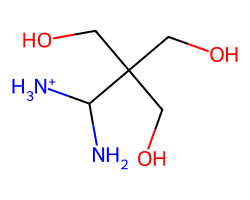

These are found symmetrical states:


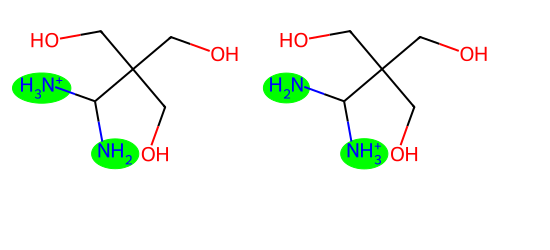

For molecule 2 symmetrical states were detected:


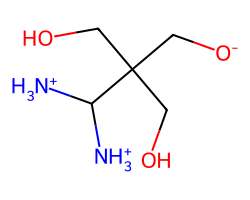

These are found symmetrical states:


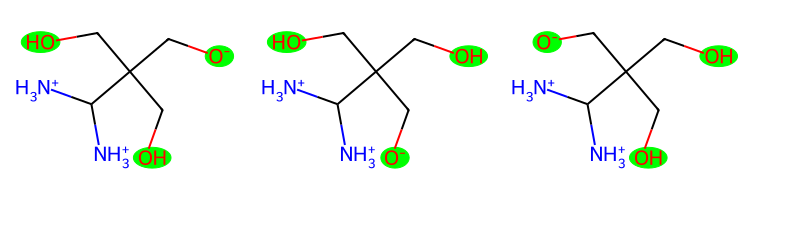

For molecule 3 symmetrical states were detected:


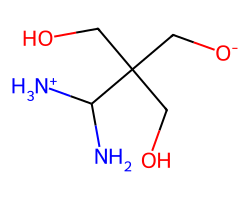

These are found symmetrical states:


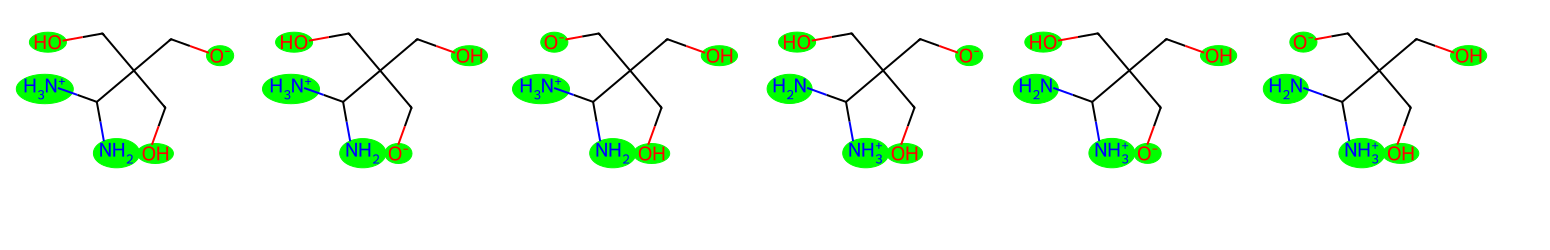

In [182]:
#@title Symmetrical states treatment
symm_states_dict = {}
color = (0.0, 1.0, 0.0, 0.2)
for idx, mol in enumerate(mols):
    if len(mol_states[idx]) == 1:
        # Only one state was found
        continue
    if not mol_states[idx][0]["use"]:
        # Even base molecule should not be used. All symmetrical copies should
        # not be used as well.
        continue
    symm_states_dict[idx] = False
    print(f"For molecule {idx} symmetrical states were detected:")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(mol_states[idx][0]["mol"])
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))
    print("These are found symmetrical states:")
    _mols = [x["mol"] for x in mol_states[idx]]
    highlight_atoms = [[] for _ in range(len(_mols))]
    highlight_colors = [{} for _ in range(len(_mols))]
    for i in range(_mols[0].GetNumAtoms()):
        if len(
            set(
                [
                    x.GetAtomWithIdx(i).GetFormalCharge() for x in _mols
                ]
            )
        ) != 1:
            for j in range(len(_mols)):
                highlight_atoms[j].append(i)
                highlight_colors[j][i] = color
    highlight_colors = tuple(x for x in highlight_colors)
    d2d = rdMolDraw2D.MolDraw2DSVG(
        250 * len(mol_states[idx]) + 50 , 250, 250, 200
    )
    d2d.DrawMolecules(_mols, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))
    # Symmetrical atoms with different charges
if not symm_states_dict:
    print(
        "No symmetrical states were found "
        + " You can skip the next step."
    )

In [183]:
#@title Select treatment of symmetrical states
#@markdown Please, select whether to inclue symmetrical states for a molecule
#@markdown or not. If for a particular molecule there are no symmetrical
#@markdown states available, selecting True won't influence the behaviour
use_symmetrical_states_molecule_0 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_1 = True #@param {type:"boolean"}
use_symmetrical_states_molecule_2 = True #@param {type:"boolean"}
use_symmetrical_states_molecule_3 = True #@param {type:"boolean"}
use_symmetrical_states_molecule_4 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_5 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_6 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_7 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_8 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_9 = False #@param {type:"boolean"}

ss = [
    use_symmetrical_states_molecule_0,
    use_symmetrical_states_molecule_1,
    use_symmetrical_states_molecule_2,
    use_symmetrical_states_molecule_3,
    use_symmetrical_states_molecule_4,
    use_symmetrical_states_molecule_5,
    use_symmetrical_states_molecule_6,
    use_symmetrical_states_molecule_7,
    use_symmetrical_states_molecule_8,
    use_symmetrical_states_molecule_9,
]

if symm_states_dict:
    for idx in symm_states_dict:
        if ss[idx]:
            for _state in mol_states[idx]:
                _state["use"] = True

We detected 2 sites to which multiple hydrogens are attached. Please, take a careful look and let us know whether we
should consider those sites as multisite with each hydrogen titrating separately, or as single site, where only one
hydrogen is titrated. Note, that we highlight the titratable sites for the molecule in the highest protonation state.


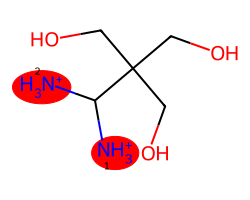

In [184]:
#@title Sites with multiple hydrogens
sites_with_multiple_hs = []
for ts in titratable_sites:
    if (
        pmol.GetAtomWithIdx(ts).GetNumExplicitHs()
        + pmol.GetAtomWithIdx(ts).GetNumImplicitHs()
        > 1
    ):
        sites_with_multiple_hs.append(ts)

import textwrap
if sites_with_multiple_hs:
    print(
        textwrap.fill(
            (
                f"We detected {len(sites_with_multiple_hs)} sites to which "
                + "multiple hydrogens are attached. Please, take a careful "
                + "look and let us know whether we should consider those sites "
                + "as multisite with each hydrogen titrating separately, or as "
                + "single site, where only one hydrogen is titrated. Note, "
                + "that we highlight the titratable sites for the molecule in "
                + "the highest protonation state."
            ),
            120
        )
    )
    colors = [(1.0, 0.0, 0.0, 0.2)]
    for i, a in enumerate(sites_with_multiple_hs):
        (pmol.GetAtomWithIdx(a)).SetProp('atomNote', str(i+1))
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    at_highlights = {x: [colors[0]] for x in sites_with_multiple_hs}
    at_rads = {x: 0.5 for x in sites_with_multiple_hs}
    d2d.DrawMoleculeWithHighlights(pmol,"", at_highlights,{}, at_rads, {})
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))
    for a in sites_with_multiple_hs:
        (pmol.GetAtomWithIdx(a)).SetProp('atomNote', '')
else:
    mHs = None
    print(
        "No sites to which multiple hydrogens are attached were detected. "
        + " You can skip the next step."
    )

In [187]:
#@title Select treatment of multi-hydrogen sites
#@markdown Do you want to treat titratable sites with multiple hydrogens
#@markdown attached as single multisite or no? Default is no. If you want
#@markdown to treat those with multisite representation tick the corresponding
#@markdown variable. The id of titratable sites are shown in the previous cell.
multiHs_titratable_site_1 = True #@param {type:"boolean"}
multiHs_titratable_site_2 = True #@param {type:"boolean"}
multiHs_titratable_site_3 = False #@param {type:"boolean"}
multiHs_titratable_site_4 = False #@param {type:"boolean"}
multiHs_titratable_site_5 = False #@param {type:"boolean"}

from copy import deepcopy
from itertools import permutations, product

mHs = [
    multiHs_titratable_site_1,
    multiHs_titratable_site_2,
    multiHs_titratable_site_3,
    multiHs_titratable_site_4,
    multiHs_titratable_site_5,
][:len(sites_with_multiple_hs)]
mhs_dict = {
    sites_with_multiple_hs[i]: mHs[i]
    for i in range(len(sites_with_multiple_hs))
}
pstate = mol_states[0][0]
for _state_id in mol_states:
    _tmp_new_states = []
    for _j, _state in enumerate(mol_states[_state_id]):
        sites_to_change = [
            _site for _site in sites_with_multiple_hs
            if (
                sum(_state["h_formal_charges"][_site]) !=
                sum(pstate["h_formal_charges"][_site])
                and mhs_dict[_site] and _state["use"]
            )
        ]
        if not sites_to_change:
            continue
        original_combination = [
            tuple(_state["h_formal_charges"][_site])
            for _site in sites_to_change
        ]
        new_combinations = []
        for _combs in (
            set(
                product(
                    *[set(permutations(x)) for x in original_combination]
                )
            ) - set(product(*[[x] for x in original_combination]))
        ):
            new_combinations.append(
                [_combs[_idx] for _idx in range(len(sites_to_change))]
            )
        for _comb in new_combinations:
            _tmp = deepcopy(_state)
            for _site_comb, _site in zip(_comb, sites_to_change):
                _tmp["h_formal_charges"][_site] = list(_site_comb)
            _tmp_new_states.append(_tmp)
    if _tmp_new_states:
        mol_states[_state_id].extend(_tmp_new_states)

In [192]:
len(mol_states[5])

3

We found the following transitions between protonation states:
Transition 0


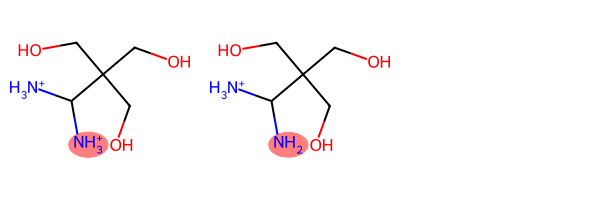

Transition 1


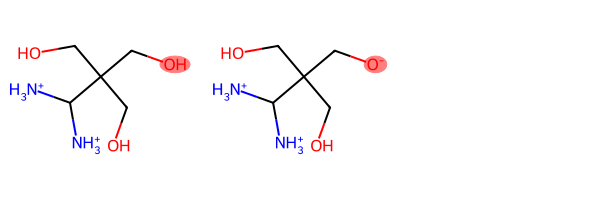

Transition 2


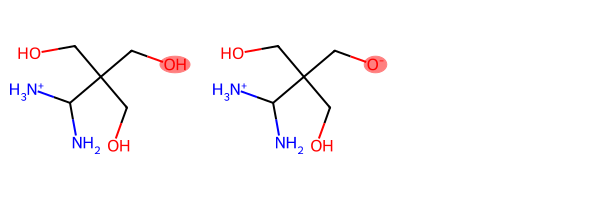

Transition 3


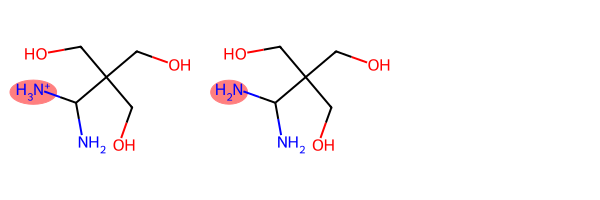

Transition 4


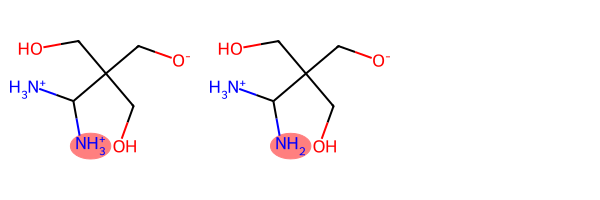

In [193]:
#@title Show state transitions
state_transitions = []
from rdkit.Chem import rdFMCS
res = rdFMCS.FindMCS([pmol, pmol])
similar_patt = Chem.MolFromSmarts(res.smartsString)
subst_matches_pmol = pmol.GetSubstructMatches(similar_patt)[0]
for i in mol_states:
    if not mol_states[i][0]["use"]:
        continue
    m1 = mol_states[i][0]["mol"]
    for j in mol_states:
        if j <= i:
            continue
        if not mol_states[j][0]["use"]:
            continue
        m2 = mol_states[j][0]["mol"]
        subst_matches1 = m1.GetSubstructMatches(similar_patt)[0]
        subst_matches2 = m2.GetSubstructMatches(similar_patt)[0]
        n_diffs = 0
        for idx in titratable_sites:
            if (
                m1.GetAtomWithIdx(
                    subst_matches1[subst_matches_pmol.index(idx)]
                ).GetFormalCharge() !=
                m2.GetAtomWithIdx(
                    subst_matches2[subst_matches_pmol.index(idx)]
                ).GetFormalCharge()
            ):
                n_diffs += 1
        if n_diffs != 1:
            continue
        state_transitions.append((i, j))

def view_difference(mol1, mol2):
    mcs = rdFMCS.FindMCS([mol1,mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    match2 = mol2.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    target_atm2 = []
    for a1, a2 in zip(match1, match2):
        if (
            mol1.GetAtomWithIdx(a1).GetFormalCharge() !=
            mol2.GetAtomWithIdx(a2).GetFormalCharge()
        ):
            target_atm1.append(a1)
            target_atm2.append(a2)
    d2d = Draw.MolsToGridImage(
        [mol1, mol2],
        highlightAtomLists=[target_atm1, target_atm2],
        useSVG = True,
    )
    display(d2d)

print("We found the following transitions between protonation states:")
for i, st_t in enumerate(state_transitions):
    print(f"Transition {i}")
    view_difference(
        mol_states[st_t[0]][0]["mol"], mol_states[st_t[1]][0]["mol"]
    )

In [194]:
#@title Provide pKa values for transitions between protonated states
#@markdown Please, provide pKa values for protonated states.
pka_0 = 2 #@param {type:"number"}
pka_1 = 3 #@param {type:"number"}
pka_2 = 4 #@param {type:"number"}
pka_3 = 5 #@param {type:"number"}
pka_4 = 6.0 #@param {type:"number"}
pka_5 = 0.0 #@param {type:"number"}
pka_6 = 0.0 #@param {type:"number"}
pka_7 = 0.0 #@param {type:"number"}
pka_8 = 0.0 #@param {type:"number"}
pka_9 = 0.0 #@param {type:"number"}

pkas = [
    pka_0, pka_1, pka_2, pka_3, pka_4,
    pka_5, pka_6, pka_7, pka_8, pka_9,
][:len(state_transitions)]

In [195]:
state_transitions

[(0, 1), (0, 2), (1, 3), (1, 4), (2, 3)]

In [196]:
#@title Generate pKa matrix equation
import numpy as np
from sympy import Matrix, MatrixSymbol, symbols

def _get_nstates_to_use(_states: dict) -> list[int]:
    """
    Get number of states to use for each protonation state.

    Parameters
    ----------
    _states: dict
        Dictionary of molecular states.

    Returns
    -------
    Number of states for each protonation state.
    """
    return [
        len(
            [
                _state for _state in _states[_idx] if _state["use"]
            ]
        ) for _idx in _states
    ]

n_states_to_use = _get_nstates_to_use(mol_states)
n_mols_to_use = len([x for x in n_states_to_use if x > 0])
mapping_to_mols_to_use = {}
_current_idx = 0
for _state_idx in mol_states:
    if mol_states[_state_idx][0]["use"]:
        mapping_to_mols_to_use[_current_idx] = _state_idx
        _current_idx += 1
assert all(x in mapping_to_mols_to_use for x in range(n_mols_to_use))

if (
    len(mol_states.keys()) == 2
    and all(x == 20 for x in n_states_to_use)
):
    print(f"Single state should be used. pKa = {pkas[0]}")
else:
    ph = symbols("pH")
    A = np.zeros(
        (
            len(state_transitions) + 1,
            n_mols_to_use,
        ),
        dtype = 'int'
    )
    b = MatrixSymbol('b', len(state_transitions) + 1, 1).as_explicit()
    bsubs = {b[0,0]: ph}
    for i, (tr, pka) in enumerate(zip(state_transitions, pkas)):
        state1 = tr[0]
        state2 = tr[1]
        n = n_states_to_use[state1]
        m = n_states_to_use[state2]
        if (
            Chem.GetFormalCharge(mol_states[state1][0]["mol"])
            > Chem.GetFormalCharge(mol_states[state2][0]["mol"])
        ):
            A[i+1, state1] =-1
            A[i+1, state2] = 1
            bsubs[b[i + 1, 0]] = pka - np.log10(n/m) - ph
        else:
            A[i+1, state1] = 1
            A[i+1, state2] = -1
            bsubs[b[i + 1, 0]] = pka - np.log10(m/n) - ph
    A[0, 0] = 1
    m = Matrix(A)
    _, inds = m.T.rref()
    removed_inds = [
        x for x in range(len(state_transitions) + 1) if x not in inds
    ]
    Ar = A[list(inds)]
    Ad = A[list(removed_inds)]
    mr = Matrix(Ar)
    md = Matrix(Ad)
    p = MatrixSymbol('p', len(mols), 1).as_explicit()
    b = b.subs(bsubs)
    br = MatrixSymbol('br', len(inds), 1).as_explicit()
    brsubs = {}
    for i, idx in enumerate(inds):
        brsubs[br[i, 0]] = b[idx, 0]

    br = br.subs(brsubs)
    br

    sol = mr.solve(br)
    print(
        "Recommended pKa values for protonations states, considering all previous "
        + "input are:"
    )
    for i in range(n_mols_to_use):
        print(f"State {mapping_to_mols_to_use[i]}: pKa = {sol[i,0]}")
        for _state in mol_states[mapping_to_mols_to_use[i]]:
            if _state["use"]:
                _state["pka"] = sol[i,0]

Recommended pKa values for protonations states, considering all previous input are:
State 0: pKa = pH
State 1: pKa = 2.77815125038364
State 2: pKa = 3.47712125471966
State 3: pKa = 7.25527250510331 - pH
State 4: pKa = 7.95424250943933 - pH


In [223]:
mol_states[1]

[{'heavy_atom_mapping': {0: 0,
   1: 1,
   2: 2,
   3: 3,
   4: 4,
   5: 5,
   6: 6,
   7: 7,
   8: 8,
   9: 9},
  'h_formal_charges': {0: [1, 1, 0],
   1: [1],
   2: [1, 1, 1],
   3: [],
   4: [1, 1],
   5: [1],
   6: [1, 1],
   7: [1],
   8: [1, 1],
   9: [1]},
  'use': True,
  'mol': <rdkit.Chem.rdchem.Mol at 0x7e2ad9a1aa40>,
  'pka': 2.77815125038364},
 {'heavy_atom_mapping': {0: 2,
   1: 1,
   2: 0,
   3: 3,
   4: 4,
   5: 5,
   6: 6,
   7: 7,
   8: 8,
   9: 9},
  'h_formal_charges': {2: [1, 1, 0],
   1: [1],
   0: [1, 1, 1],
   3: [],
   4: [1, 1],
   5: [1],
   6: [1, 1],
   7: [1],
   8: [1, 1],
   9: [1]},
  'use': True,
  'mol': <rdkit.Chem.rdchem.Mol at 0x7e2ad9a1b610>,
  'pka': 2.77815125038364},
 {'heavy_atom_mapping': {0: 0,
   1: 1,
   2: 2,
   3: 3,
   4: 4,
   5: 5,
   6: 6,
   7: 7,
   8: 8,
   9: 9},
  'h_formal_charges': {0: [0, 1, 1],
   1: [1],
   2: [1, 1, 1],
   3: [],
   4: [1, 1],
   5: [1],
   6: [1, 1],
   7: [1],
   8: [1, 1],
   9: [1]},
  'use': True,
  '

In [222]:
#@title Topology and structure general behavior
#@markdown Do you want us to generate topology and molecule structure with
#@markdown Open Force Field? If no, you would need to provide topologies in
#@markdown **.itp** format in the following steps.
is_generation_needed = True #@param {type:"boolean"}
ff_to_use = "openff-2.2.0.offxml" #@param {type:"string"}
molecule_name = "MOL" #@param {type:"string"}
_mols = []
_states_to_use = []
if is_generation_needed:
    ff = ForceField(ff_to_use)
    for _state_idx in mol_states:
        # We skip mol state if first state is not used
        if not mol_states[_state_idx][0]["use"]:
            continue
        _states_to_use.append(_state_idx)
        _m = Molecule.from_rdkit(
            mol_states[_state_idx][0]["mol"],
            allow_undefined_stereo=True)
        _m.generate_conformers()
        interchange = ff.create_interchange(_m.to_topology())
        _state_heavy_atom_charges = [
            a.partial_charge.magnitude for a in interchange.topology.atoms
            if a.atomic_number != 1
        ]
        _state_heavy_atom_charges_in_pmol_indexing = (
            [0] * len(_state_heavy_atom_charges)
        )
        for i, j in mol_states[_state_idx][0]["heavy_atom_mapping"].items():
            _state_heavy_atom_charges_in_pmol_indexing[j] = (
                _state_heavy_atom_charges[i]
            )

        _hydrogen_map = {
            a.molecule_atom_index: {
                "hidx": [
                    atom.molecule_atom_index for atom in a.bonded_atoms
                    if atom.atomic_number == 1
                ],
                "charges": [
                    atom.partial_charge.magnitude for atom in a.bonded_atoms
                    if atom.atomic_number == 1
                ],
            } for a in interchange.topology.atoms if a.atomic_number != 1
        }
        print(_state_heavy_atom_charges)
        print(_hydrogen_map)
        print(mol_states[_state_idx][0]["h_formal_charges"])
        _mols.append(_m.to_rdkit())
        _rdmol = _m.to_rdkit()

        # Write parameters
        if _state_idx == 0:
            interchange.to_gromacs(f"molecule_{_state_idx}")
        else:
            interchange.to_top(f"molecule_{_state_idx}.top")

        # Generate charges for states
"""
_base_mol = _mols[0]
charge_table =[charges[0]]
_charge_table_basic = [charges[0]]

# We iterate over molecules and table of charges
for _state_id, _mol, _charges in zip(
    _states_to_use[1:], _mols[1:], charges[1:]
):
    for state in
    mcs = rdFMCS.FindMCS([_base_mol, _m])
    # We perform mcs search
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = _base_mol.GetSubstructMatch(mcs_mol)
    match2 = _m.GetSubstructMatch(mcs_mol)

    _tmp_to_cmp = _basic_treatment(_i, match1, match2, _c)
    # No symmetry sites and no mhs sites
    if states[_i+1][2] == 1:
        _tmp = _basic_treatment(_i, match1, match2, _c)
    # Only mhs are present
    elif not states[_i+1][3]:
        _tmp = _only_mhs_treatment(_i, match1, match2, _c)
    elif not states[_i+1][4]:
        _tmp = _only_sym_treatment(_i, match1, match2, _c)
    else:
        _tmp = _ss_mhs_treatment(_i, match1, match2, _c)
        print(_tmp)
    for x in _tmp:
        charge_table.append(_tmp[x])
    for x in _tmp_to_cmp:
        _charge_table_basic.append(_tmp_to_cmp[x])
print(np.array(charge_table).T)
assert all(x in charge_table for x in _charge_table_basic), "All simple charge lists should be in complex"
"""

[-0.8711384615384615, 0.3566615384615385, -0.8711384615384615, -0.11303846153846156, 0.12202853846153844, -0.6588384615384616, 0.12202853846153844, -0.6588384615384616, 0.12202853846153844, -0.6588384615384616]
{0: {'hidx': [10, 11, 12], 'charges': [0.4982615384615385, 0.4982615384615385, 0.4982615384615385]}, 1: {'hidx': [13], 'charges': [0.17966153846153846]}, 2: {'hidx': [14, 15, 16], 'charges': [0.4982615384615385, 0.4982615384615385, 0.4982615384615385]}, 3: {'hidx': [], 'charges': []}, 4: {'hidx': [17, 18], 'charges': [0.08266153846153844, 0.08266153846153844]}, 5: {'hidx': [19], 'charges': [0.48129453846153847]}, 6: {'hidx': [20, 21], 'charges': [0.08266153846153844, 0.08266153846153844]}, 7: {'hidx': [22], 'charges': [0.48129453846153847]}, 8: {'hidx': [23, 24], 'charges': [0.08266153846153844, 0.08266153846153844]}, 9: {'hidx': [25], 'charges': [0.48129453846153847]}}
{0: [1, 1, 1], 1: [1], 2: [1, 1, 1], 3: [], 4: [1, 1], 5: [1], 6: [1, 1], 7: [1], 8: [1, 1], 9: [1]}


/usr/local/lib/python3.10/site-packages/openff/interchange/interop/gromacs/export/_export.py:48: UserWarning: WARNING: System defined with no box vectors, which GROMACS does not offically support in versions 2020 or newer (see https://gitlab.com/gromacs/gromacs/-/issues/3526). Setting box vectors to a 5  nm cube.
  self._write_gro(gro, decimal)


[-0.97184, 0.43866, -0.8686400000000001, -0.14104, 0.13035999999999998, -0.637507, 0.13035999999999998, -0.637507, 0.13035999999999998, -0.637507]
{0: {'hidx': [10, 11], 'charges': [0.42826000000000003, 0.42826000000000003]}, 1: {'hidx': [12], 'charges': [0.09766]}, 2: {'hidx': [13, 14, 15], 'charges': [0.46342700000000003, 0.46342700000000003, 0.46342700000000003]}, 3: {'hidx': [], 'charges': []}, 4: {'hidx': [16, 17], 'charges': [0.06266000000000001, 0.06266000000000001]}, 5: {'hidx': [18], 'charges': [0.44796]}, 6: {'hidx': [19, 20], 'charges': [0.06266000000000001, 0.06266000000000001]}, 7: {'hidx': [21], 'charges': [0.44796]}, 8: {'hidx': [22, 23], 'charges': [0.06266000000000001, 0.06266000000000001]}, 9: {'hidx': [24], 'charges': [0.44796]}}
{0: [1, 1, 0], 1: [1], 2: [1, 1, 1], 3: [], 4: [1, 1], 5: [1], 6: [1, 1], 7: [1], 8: [1, 1], 9: [1]}
[-1.0165600799999999, 0.16973991999999996, -1.0165600799999999, -0.11196008000000002, 0.43213991999999996, -0.54846008, 0.14193991999999997,

'\n_base_mol = _mols[0]\ncharge_table =[charges[0]]\n_charge_table_basic = [charges[0]]\n\n# We iterate over molecules and table of charges\nfor _state_id, _mol, _charges in zip(\n    _states_to_use[1:], _mols[1:], charges[1:]\n):\n    for state in \n    mcs = rdFMCS.FindMCS([_base_mol, _m])\n    # We perform mcs search\n    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)\n    match1 = _base_mol.GetSubstructMatch(mcs_mol)\n    match2 = _m.GetSubstructMatch(mcs_mol)\n\n    _tmp_to_cmp = _basic_treatment(_i, match1, match2, _c)\n    # No symmetry sites and no mhs sites\n    if states[_i+1][2] == 1:\n        _tmp = _basic_treatment(_i, match1, match2, _c)\n    # Only mhs are present\n    elif not states[_i+1][3]:\n        _tmp = _only_mhs_treatment(_i, match1, match2, _c)\n    elif not states[_i+1][4]:\n        _tmp = _only_sym_treatment(_i, match1, match2, _c)\n    else:\n        _tmp = _ss_mhs_treatment(_i, match1, match2, _c)\n        print(_tmp)\n    for x in _tmp:\n        charge_tabl

In [219]:
a = list(interchange.topology.atoms)[15]
list(a.bonded_atoms)[0]

Atom(name=, atomic number=6)

In [198]:
pmol.GetAtomWithIdx(1).GetChiralTag()

rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED

In [204]:
for atom_idx, atom in enumerate(mol_states[2][0]["mol"].GetAtoms()):
    print(atom_idx, atom.GetChiralTag(), atom.HasProp("_ChiralityPossible"))

0 CHI_UNSPECIFIED 0
1 CHI_UNSPECIFIED 0
2 CHI_UNSPECIFIED 0
3 CHI_UNSPECIFIED 0
4 CHI_UNSPECIFIED 0
5 CHI_UNSPECIFIED 0
6 CHI_UNSPECIFIED 0
7 CHI_UNSPECIFIED 0
8 CHI_UNSPECIFIED 0
9 CHI_UNSPECIFIED 0


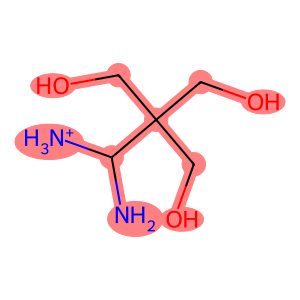

In [206]:
mol_states[1][0]["mol"]

In [ ]:
# We need to transform top to itp and also for the future
# needs we need the functionality for parsing atoms and
# bonds sections. This will allow us to generate molecular
# graphs, which in turn, will allow us to compare molecules
# and prepare data for constant pH.
"""
We need to support two types of behaviour:
1. Easy case
    We generate molecule our selves with OpenFF.
    In this case we actually know what is the order atoms in
    all protonation states and we can easily do matching.
    We also know what to do with all possible states -
    symmetrical and with multiple hydrogens. From created
    interchanges and topology files we can get all the
    partial charges and then using rdkit and we can generate
    correct charge lists.
    We start by implementing this.
2. More complex case
    The topologies are provided by the user. In this case
    we:
        (i) expect that the user will provide us not only
            with the topologies, but also with structures
            for all states
        (ii) don't expect that the order of atoms is the
            same as in RdKit.
    We will reconstruct the order based on rdkit functionality
    https://greglandrum.github.io/rdkit-blog/posts/2022-12-18-introducing-rdDetermineBonds.html

    NOTE: in principal, the first case can also be treated
    as the second. But we will add it later.
In general, we need to read top/itp files (for now we always
expect [ atoms ] section to be present) and assign charges
in the order of mols[0]. For each state we additionally
treap symmetrical states and multi-H states. Then we change
the order according to the order in the first file.
"""
class GMX_topology:
    """
    Reads gromacs topology file and parses some of the sections.

    Parameters
    ----------
    gmx_top: str
        GROMACS topology file

    Attributes
    ----------
    blocks: Dict[str, str]
        Dictionary of blocks available in the topology file
    atoms: list

    Methods
    -------
    parse_atoms()
        Parse atom section if present. Generates at
    parse_atomtypes()
        Parse atomtypes section if present.
    parse_bonds()
        Parse bonds.


    """
    def __init__(self, gmx_top):
        self.blocks = {}
        with open(gmx_top, "r") as top:
            section = None
            tmp = []
            for line in top:
                if line.strip().startswith("["):
                    if section:
                        if section in self.blocks:
                            self.blocks[section] += [tmp]
                        else:
                            self.blocks[section] = [tmp]
                    else:
                        self.blocks["header"] = [tmp]
                    section = line.strip()[1:-1].strip()
                    tmp = []
                else:
                    tmp += [line]
            if section in self.blocks:
                self.blocks[section] += [tmp]
            else:
                self.blocks[section] = [tmp]

    def parse_atoms(self):
        """
        Parse atoms block. As a result, creates atoms attribute, where for each
        atom in the provided topology atomtype and index are stored
        """
        if "atoms" not in self.blocks:
            self.atoms = []
        else:
            self.atoms = []
            for section in self.blocks["atoms"]:
                for line in section:
                    # Skip non-informative lines
                    if line.strip().startswith(";"):
                        continue
                    if line.strip().startswith("#"):
                        continue
                    if not line.strip():
                        continue
                    self.atoms.append(
                        (
                            int(line.split()[0]) - 1,
                            line.split()[1],
                        )
                    )

    def parse_dihedrals(self):
        """
        Parse dihedral section of the topology. Only dihdrals of type 1 and 9
        with explicitly provided parameters are taken into account.
        """
        if "dihedrals" not in self.blocks:
            self.dihedrals = []
        else:
            self.dihedrals = []
            for section in self.blocks["dihedrals"]:
                for line in section:
                    # Skip non-informative lines
                    if line.strip().startswith(";"):
                        continue
                    if line.strip().startswith("#"):
                        continue
                    if not line.strip():
                        continue
                    if int(line.split()[4]) not in [1, 9]:
                        continue
                    if len(line.split()) < 8:
                        continue
                    self.dihedrals.append(
                        (
                            int(line.split()[0])-1,
                            int(line.split()[1])-1,
                            int(line.split()[2])-1,
                            int(line.split()[3])-1,
                            line
                        )
                    )

    def parse_dihedraltypes(self):
        """
        Parse dihedraltypes section in the topology if present. Creates
        dihedraltypes attribute, where types and of 4 atoms are provided
        and also the corresponding dihedral string (to ease the search in
        topology file). All imporpers and Fourier dihedrals are for now
        excluded. Thus, only type 1 and 9 are supported.
        https://manual.gromacs.org/current/reference-manual/topologies/topology-file-formats.html

        NOTE: We also should somehow iterate through difened torsions if they
        are present.
        """
        if "dihedraltypes" not in self.blocks:
            self.dihedraltypes = []
        else:
            self.dihedraltypes = []
            for section in self.blocks["dihedraltypes"]:
                for line in section:
                    # Skip non-informative lines
                    if line.strip().startswith(";"):
                        continue
                    if line.strip().startswith("#"):
                        continue
                    if not line.strip():
                        continue
                    if int(line.split()[4]) not in [1, 9]:
                        continue
                    self.dihedraltypes.append(
                        (
                            line.split()[0],
                            line.split()[1],
                            line.split()[2],
                            line.split()[3],
                            line[:(line.rfind(line.split()[3]) + len(line.split()[3]))].strip()
                        )
                    )

This is Molecule 0


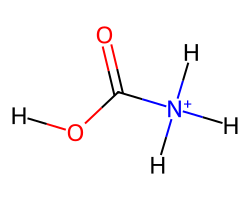

This is Molecule 1


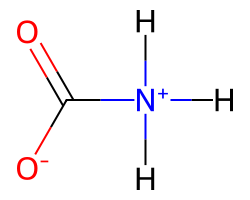

In [ ]:
#@title Provide topologies data
#@markdown If parameterisation is needed, all included molecules will be
#@markdown parameterized with open force field. If not, for all
is_parameterisation_needed = True #@param {type:"boolean"}
included_mols = [m for m,i in zip(mols, incl) if i]
included_svgs = [s for s,i in zip(svgs, incl) if i]
for i, s in enumerate(included_svgs):
    print(f"This is Molecule {i}")
    display(SVG(svgs[i]))

parameters_for_molecule_0 = "" #@param {type:"string"}
parameters_for_molecule_1 = "" #@param {type:"string"}
parameters_for_molecule_2 = "" #@param {type:"string"}
parameters_for_molecule_3 = "" #@param {type:"string"}
parameters_for_molecule_4 = "" #@param {type:"string"}

In [ ]:
from openff.interchange import Interchange

In [ ]:
inter = Interchange.from_smirnoff(force_field=ff, topology=top)

In [ ]:
inter.to_top("test.top")